<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP1</h2></center>

# Importation des librairies nécessaire à la réalisation du TP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax, Nadam, Adagrad
from keras.api._v2.keras.callbacks import ModelCheckpoint

# Configuration de l'environement afin d'utiliser le GPU lors de l'entrainement des modèles

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=True)

# Visualisation et prétraitement des données

## Echantillionnage

Nous visualisons un échantillon de données pour comprendre le contenu du dataset et vérifier si les images sont correctement chargées et étiquetées.

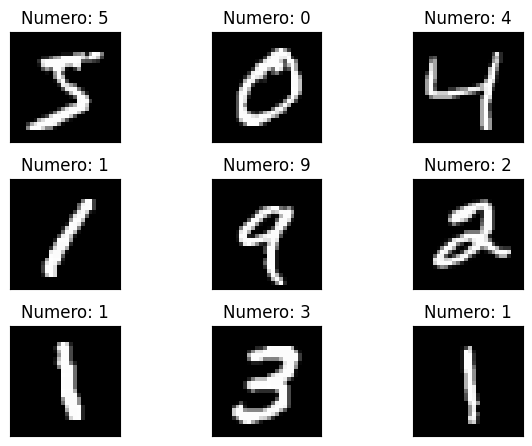

In [ ]:
# On affiche des valeurs random de notre dataset
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Numero: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

Nous pouvons constater que nous sommes face à un dataset d'image de chiffre manuscrit et les données sont correctement labélisées

## Analyse approfondi d'une instance de notre jeu de données

Dans cet étape nous visualisons à la fois l'apparence de l'image et la distribution des niveaux de gris qui la composent afin d'avoir une idée sur le prétraitement des données

Text(0.5, 1.0, 'Distribution des pixels')

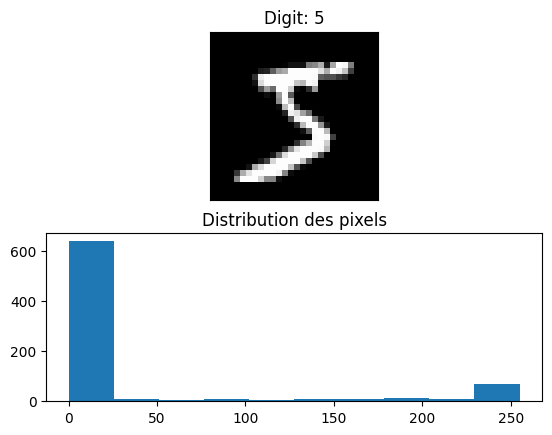

In [ ]:
# On visualise la distribution des pixels pour voir le type de prétraitement à appliquer
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Distribution des pixels")

## Prétraitement des données

On effectue un prétraitements de nos données afin de les avoir au format adapté pour l'entrainement de notre modèle

In [ ]:
# On affiche les dimensions initials de nos données
print("X_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

# On convertie nos paramètres d'entrée du format 28*28 au format 784*1 pour pouvoir les utiliser dans notre modèle
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(5000, 784)
X_val = X_val.reshape(5000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# on normalise les données entre 0 e 1 pour uniformiser l'entrainement
X_train /= 255
X_test /= 255
X_val /= 255

# On affiche le résultat du pretraitement
print("dimensions des variables indépendantes d'entraintement", X_train.shape)
print("dimensions des variables indépendantes de test", X_test.shape)
print("dimensions des variables indépendantes de validation", X_val.shape)

# On encode nos variables y en utilisant le one hot encoding
n_classes = 10

Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)
Y_val = Y_test = to_categorical(y_val, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

X_train shape : (60000, 28, 28)
y_train shape : (60000,)
X_test shape : (5000, 28, 28)
y_test shape : (5000,)
dimensions des variables indépendantes d'entraintement (60000, 784)
dimensions des variables indépendantes de test (5000, 784)
dimensions des variables indépendantes de validation (5000, 784)
Shape after one-hot encoding:  (60000, 10)


- Les images du MNIST dataset ont initialement une dimension de 28x28 pixels, ce qui fait un total de 784 pixels par image. Nous réalisons cette transformation car notre modèle de deep learning reçoient les données en entré sous un format unidimensionnelles.
- On convertit aussi les valeurs des pixels en nombres à virgule flottante de 32 bits afin d'augmenter la précision des opérations mathématiques.
- Nous divisions nos valeurs par 255 afin de les normaliser entre 0 et 1. Nous faisons cela afin de les ramener à une échelle commune ce qui comme effet d'aider a la convergence du modèle.
- On utilise le one hot encoding sur nos variables dépendantes afin de représenter nos classes afin de faciliter leurs compréhensions par notre modèle

# Entrainement de modèles en utilisant différents hyper paramètres

On initialise différents hyper paramètres (nombre de neurones, nombre d'epoch, fonction d'activation, taux d'apprentissage, taille des batchs), afin de voir leurs différents impactent sur les performances de nos modèles

In [ ]:
nb_neurones = [128, 256, 512, 1024]
nb_epoch = [20, 30, 50, 100]
activation_functions = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_size = [16, 32, 64, 128]

titles = ["Nombre de neurones", "Fonction d'activation", "Learning rate", "Batch size", "Nombre d'epoch", "Accuracy", "Loss", "Val_accuracy", "Val_loss"]
gridsearch = []

On entraine plusieurs modèles avec des combinaisons d'hyperparamètres différentes (768 modèles en tout chaqu'un avec une combinaison unique d'hyperparamètres) et on sauvegarde leurs performances (Accuracy, Loss, Validation Accuracy, Validation Loss)

In [ ]:
for nbe in nb_epoch:
  for bs in batch_size:
    for learning_rate in learning_rates:
      for activation_function in activation_functions:
        for nbn in nb_neurones:
            with tf.device(device_name):
              # On crée un modèle de classification simple
              model = Sequential()
              model.add(Dense(nbn, input_shape=(784,)))
              model.add(Activation(activation_function))

              model.add(Dense(10))
              model.add(Activation('softmax'))

              # on compile notre modèle
              model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))

              # Entrainement du modèle sur "nbe" epochs
              history = model.fit(X_train, Y_train,
                        batch_size=bs, epochs=nbe,
                        verbose=0,
                        validation_data=(X_val, Y_val))

              result = [nbn, activation_function, learning_rate, bs, nbe, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], history.history['val_loss'][-1]]

              gridsearch.append(result)

On sauvegarde les résultats dans un fichier csv

In [ ]:
benchmark = pd.DataFrame(data=gridsearch, columns=titles)
benchmark.to_csv('gridsearch_results.csv', index=False)
benchmark

,Nombre de neurones,Fonction d'activation,Learning rate,Batch size,Nombre d'epoch,Accuracy,Loss,Val_accuracy,Val_loss
0,128,relu,0.001,32,20,0.999100,0.004081,0.979200,0.085568
1,256,relu,0.001,32,20,1.000000,0.000400,0.983700,0.071445
2,512,tanh,0.010,32,20,0.996283,0.019224,0.979900,0.061165
3,1024,tanh,0.010,32,20,0.994733,0.022603,0.981000,0.064401
4,512,relu,0.001,32,20,1.000000,0.000189,0.983800,0.068192
...,...,...,...,...,...,...,...,...,...
763,256,relu,0.010,128,30,0.985823,0.052555,0.972985,0.101683
764,512,sigmoid,0.001,16,50,0.987877,0.044709,0.974236,0.100290
765,256,tanh,0.100,64,50,0.981624,0.067210,0.969767,0.113403
766,256,tanh,0.010,128,50,0.985690,0.053003,0.972705,0.102075


# Analyse des résultats

Afin de voir les modèles les plus performants on les ordonnes avec ceux ayant l'Accuracy et la Val_accuracy la plus élevé

In [ ]:
benchmark = pd.read_csv('gridsearch_results.csv')
# sort it by accuracy
benchmark.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

benchmark.head(10)

,Nombre de neurones,Fonction d'activation,Learning rate,Batch size,Nombre d'epoch,Accuracy,Loss,Val_accuracy,Val_loss
583,1024,relu,0.0001,64,100,1.0,0.000001,0.9864,0.094491
351,1024,relu,0.0010,16,50,1.0,0.000003,0.9860,0.109276
350,512,relu,0.0010,16,50,1.0,0.000004,0.9858,0.098275
400,1024,relu,0.0010,32,50,1.0,0.000035,0.9856,0.070207
458,512,relu,0.0001,64,50,1.0,0.000006,0.9854,0.091367
582,512,relu,0.0001,64,100,1.0,0.000002,0.9853,0.099454
631,1024,relu,0.0001,128,100,1.0,0.000006,0.9852,0.076279
193,512,relu,0.0010,32,30,1.0,0.000096,0.9850,0.067318
459,1024,relu,0.0001,64,50,1.0,0.000004,0.9850,0.102535
5,1024,relu,0.0010,32,20,1.0,0.000130,0.9849,0.065904


Les modèles obtenu ont effectivement une excellente accuracy et validation accuracy cependant il faut noter un écart très important entre la loss et la val loss ce qui est signe de surapprentissage. Afin de pouvoir donc obtenir nos modèles les plus performants nous devons donc chercher les modèles avec l'accuracy et val_accuracy les plus élevés mais aussi l'écart le plus petit entre Loss et val loss

In [ ]:
benchmark["Ecart loss/val_loss"] = 1 - np.abs(benchmark["Loss"] - benchmark["Val_loss"])

benchmark.sort_values(by=['Ecart loss/val_loss', 'Accuracy'], ascending=[False, False], inplace=True)

benchmark

,Nombre de neurones,Fonction d'activation,Learning rate,Batch size,Nombre d'epoch,Accuracy,Loss,Val_accuracy,Val_loss,Ecart loss/val_loss
377,128,sigmoid,0.1000,32,50,0.946267,0.189631,0.9455,0.189610,0.999979
296,256,sigmoid,0.0100,128,30,0.947867,0.184795,0.9467,0.184842,0.999953
298,1024,sigmoid,0.0100,128,30,0.932900,0.239298,0.9309,0.238924,0.999626
124,128,sigmoid,0.1000,16,30,0.949700,0.176680,0.9492,0.176291,0.999610
379,512,sigmoid,0.1000,32,50,0.934733,0.231958,0.9341,0.232358,0.999600
...,...,...,...,...,...,...,...,...,...,...
157,512,relu,0.0001,16,30,0.998700,0.004716,0.9822,0.178675,0.826041
412,1024,relu,0.0001,32,50,0.999533,0.002151,0.9824,0.188203,0.813948
362,256,relu,0.0001,16,50,0.998767,0.004646,0.9810,0.194134,0.810512
364,1024,relu,0.0001,16,50,0.999367,0.003295,0.9843,0.203403,0.799892


Cela nous donne serte des modèles n'ayant pas de problème de sur apprentissage mais ils ne sont pas pour autant les plus performants une meillieure manière serait donc d'utiliser un treshold

In [ ]:
condition = np.abs(benchmark["Loss"] - benchmark["Val_loss"]) < 0.025
benchmark[condition].head(20)

,Nombre de neurones,Fonction d'activation,Learning rate,Batch size,Nombre d'epoch,Accuracy,Loss,Val_accuracy,Val_loss
87,1024,relu,0.010,128,20,0.988483,0.046101,0.9793,0.069449
53,128,sigmoid,0.001,64,20,0.987783,0.047474,0.9776,0.071858
262,1024,relu,0.100,16,20,0.987367,0.050241,0.9791,0.073583
86,512,relu,0.010,128,20,0.986817,0.051696,0.9770,0.076430
261,512,relu,0.100,16,20,0.986183,0.053173,0.9780,0.076313
307,128,sigmoid,0.001,128,30,0.986017,0.052173,0.9760,0.076622
276,256,sigmoid,0.010,16,20,0.985083,0.054114,0.9755,0.074676
275,128,sigmoid,0.010,16,20,0.985033,0.055460,0.9749,0.079493
301,512,tanh,0.010,128,30,0.984933,0.057298,0.9757,0.080928
85,256,relu,0.010,128,20,0.984650,0.058770,0.9757,0.079575


Comme nous pouvons le constater nous avons plusieurs modèles très performants avec une précision égale ou sup a 98% et un écart entre la loss et la val loss assez faible montrant que notre modèle ne souffre pas de sur apprentissage et cela pour des combinaisons différentes d'hyperparamètre.

## Analyse approfondie de l'impacte des hyperparamètres

### Nombre de neurones

In [ ]:
nbn_df = benchmark.groupby(["Nombre de neurones"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
nbn_df.reset_index(inplace=True)
nbn_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
nbn_df = nbn_df[["Nombre de neurones", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

nbn_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

nbn_df

,Nombre de neurones,Accuracy,Val_accuracy,Ecart loss/val_loss
0,128,0.986086,0.972073,0.081487
1,256,0.985978,0.972970,0.071045
2,512,0.985474,0.973032,0.041941
3,1024,0.984936,0.972428,0.041797


On peut noter que les différences sont relativement modeste montrant qu'en moyenne l'impacte du nombre de neurones sur cette tache de classification reste moindre cependant on peut quand meme noter une généralisation légèrement meillieure plus le nombre de neurones est élevé (Val_acc et Ecart loss/val_loss légérement meillieur lorsque le nombre de neurones augmentent)

### Fonction d'activation

In [ ]:
fa_df = benchmark.groupby(["Fonction d'activation"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
fa_df.reset_index(inplace=True)
fa_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
fa_df = fa_df[["Fonction d'activation", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

fa_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

fa_df

,Fonction d'activation,Accuracy,Val_accuracy,Ecart loss/val_loss
0,relu,0.992395,0.977932,0.081487
2,tanh,0.988743,0.974650,0.041941
1,sigmoid,0.975718,0.965296,0.071045


On note de meillieur résultat de relu ce qui est généralement le cas pour les taches de classification du à son adaptabilité et sa non saturation. Cependant on note que tanh reste la moins suceptible au sur apprentissage et qui peut s'avérer comme un meillieur compromis mais relu reste globalement préférable

### Learning Rate

In [ ]:
lr_df = benchmark.groupby(["Learning rate"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
lr_df.reset_index(inplace=True)
lr_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
lr_df = lr_df[["Learning rate", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

lr_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

lr_df

,Learning rate,Accuracy,Val_accuracy,Ecart loss/val_loss
0,0.0001,0.997573,0.980548,0.081487
1,0.0010,0.997187,0.980743,0.071045
2,0.0100,0.988024,0.974896,0.041941
3,0.1000,0.959691,0.954317,0.041797


L'analyse ici est assez simple plus le learning rate est bas plus la précision augmante mais plus le risque de sur apprentissage devient élevé.

### Batch Size

In [ ]:
bs_df = benchmark.groupby(["Batch size"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
bs_df.reset_index(inplace=True)
bs_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
bs_df = bs_df[["Batch size", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

bs_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

bs_df

,Batch size,Accuracy,Val_accuracy,Ecart loss/val_loss
0,16,0.992551,0.977572,0.081487
1,32,0.986947,0.973758,0.071045
2,64,0.985912,0.972834,0.041941
3,128,0.977064,0.966340,0.041797


L'analyse ici est assez simple plus le learning rate est bas plus la précision augmante mais plus le risque de sur apprentissage devient élevé.

### Nombre d'epoch

In [ ]:
nbe_df = benchmark.groupby(["Nombre d'epoch"])[["Accuracy", "Loss", "Val_accuracy", "Val_loss"]].mean()
nbe_df.reset_index(inplace=True)
nbe_df["Ecart loss/val_loss"] = np.abs(benchmark["Loss"] - benchmark["Val_loss"])
nbe_df = nbe_df[["Nombre d'epoch", "Accuracy", "Val_accuracy", "Ecart loss/val_loss"]]

nbe_df.sort_values(by=['Accuracy', 'Val_accuracy'], ascending=[False, False], inplace=True)

nbe_df

,Nombre d'epoch,Accuracy,Val_accuracy,Ecart loss/val_loss
3,100,0.989924,0.975627,0.041797
2,50,0.988483,0.974557,0.041941
1,30,0.985262,0.972477,0.071045
0,20,0.978805,0.967842,0.081487


Ici on peut voir qu'en moyenne plus le nombre d'epoch est élevé plus les résultats sont pertinant

# Analyse du meillieur modèle

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.01))

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=128, epochs=20,
            verbose=2,
            validation_data=(X_val, Y_val))

Epoch 1/20
469/469 - 7s - loss: 0.7622 - accuracy: 0.8113 - val_loss: 0.3389 - val_accuracy: 0.9095 - 7s/epoch - 14ms/step
Epoch 2/20
469/469 - 1s - loss: 0.3082 - accuracy: 0.9157 - val_loss: 0.2606 - val_accuracy: 0.9266 - 1s/epoch - 3ms/step
Epoch 3/20
469/469 - 1s - loss: 0.2448 - accuracy: 0.9320 - val_loss: 0.2148 - val_accuracy: 0.9407 - 1s/epoch - 3ms/step
Epoch 4/20
469/469 - 1s - loss: 0.2040 - accuracy: 0.9434 - val_loss: 0.1824 - val_accuracy: 0.9486 - 1s/epoch - 3ms/step
Epoch 5/20
469/469 - 2s - loss: 0.1737 - accuracy: 0.9514 - val_loss: 0.1599 - val_accuracy: 0.9547 - 2s/epoch - 3ms/step
Epoch 6/20
469/469 - 2s - loss: 0.1508 - accuracy: 0.9586 - val_loss: 0.1425 - val_accuracy: 0.9581 - 2s/epoch - 4ms/step
Epoch 7/20
469/469 - 1s - loss: 0.1323 - accuracy: 0.9633 - val_loss: 0.1304 - val_accuracy: 0.9625 - 1s/epoch - 3ms/step
Epoch 8/20
469/469 - 1s - loss: 0.1179 - accuracy: 0.9677 - val_loss: 0.1213 - val_accuracy: 0.9652 - 1s/epoch - 3ms/step
Epoch 9/20
469/469 - 1s

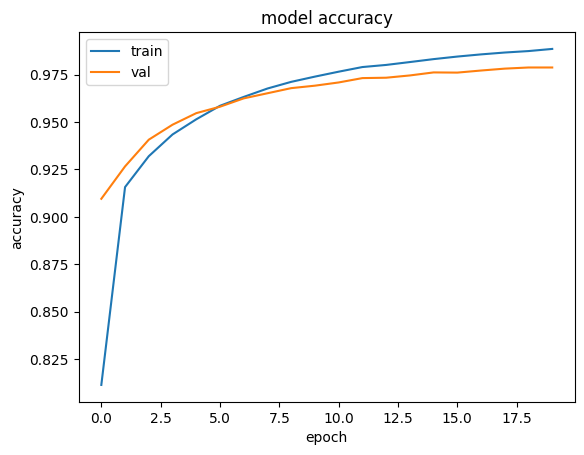

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

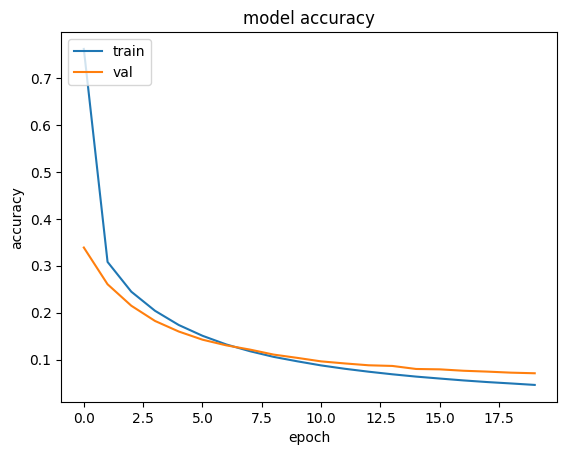

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

313/313 [==============================] - 1s 1ms/step


Text(95.72222222222221, 0.5, 'Truth')

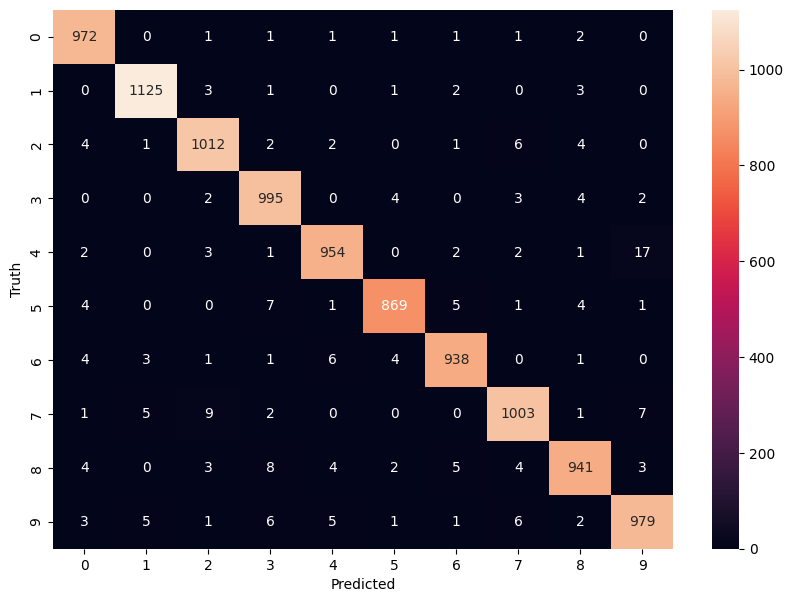

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Analyse du meillieur modèle avec dropout

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.01))

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=128, epochs=20,
            verbose=2,
            validation_data=(X_val, Y_val))

Epoch 1/20
469/469 - 2s - loss: 2.2994 - accuracy: 0.1273 - val_loss: 2.2970 - val_accuracy: 0.1152 - 2s/epoch - 5ms/step
Epoch 2/20
469/469 - 1s - loss: 2.2981 - accuracy: 0.1124 - val_loss: 2.2961 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 3/20
469/469 - 2s - loss: 2.2971 - accuracy: 0.1129 - val_loss: 2.2947 - val_accuracy: 0.1152 - 2s/epoch - 4ms/step
Epoch 4/20
469/469 - 1s - loss: 2.2958 - accuracy: 0.1125 - val_loss: 2.2935 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 5/20
469/469 - 1s - loss: 2.2944 - accuracy: 0.1169 - val_loss: 2.2915 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 6/20
469/469 - 1s - loss: 2.2926 - accuracy: 0.1173 - val_loss: 2.2898 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 7/20
469/469 - 1s - loss: 2.2907 - accuracy: 0.1147 - val_loss: 2.2877 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 8/20
469/469 - 1s - loss: 2.2884 - accuracy: 0.1195 - val_loss: 2.2846 - val_accuracy: 0.1154 - 1s/epoch - 3ms/step
Epoch 9/20
469/469 - 1s 

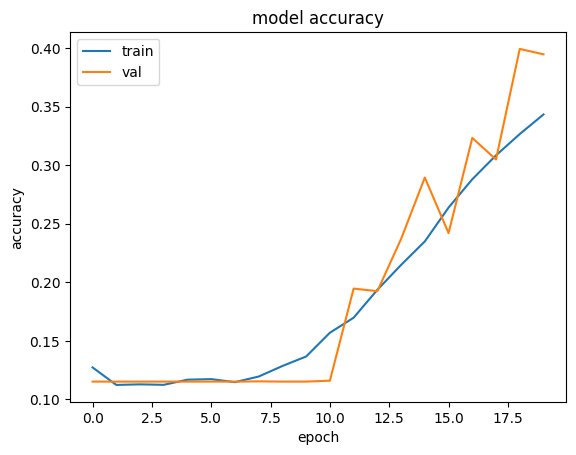

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

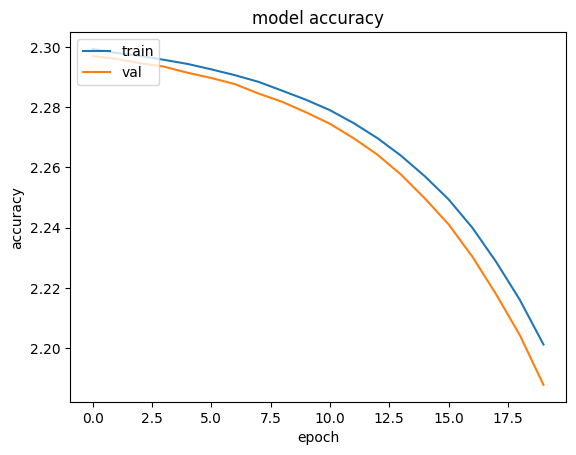

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

157/157 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

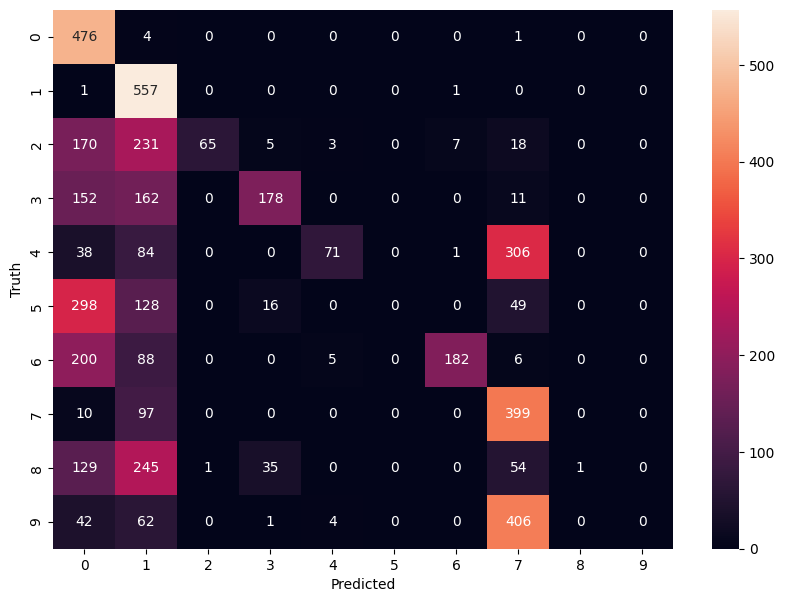

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


# Analyse du meillieur modèle avec dropout + early stopping

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.01))

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=128, epochs=500,
            verbose=2,
            callbacks=[callback],
            validation_data=(X_val, Y_val))

Epoch 1/500
469/469 - 2s - loss: 2.2994 - accuracy: 0.1166 - val_loss: 2.2972 - val_accuracy: 0.1152 - 2s/epoch - 5ms/step
Epoch 2/500
469/469 - 1s - loss: 2.2980 - accuracy: 0.1145 - val_loss: 2.2960 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 3/500
469/469 - 1s - loss: 2.2969 - accuracy: 0.1124 - val_loss: 2.2947 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 4/500
469/469 - 2s - loss: 2.2956 - accuracy: 0.1130 - val_loss: 2.2933 - val_accuracy: 0.1152 - 2s/epoch - 4ms/step
Epoch 5/500
469/469 - 2s - loss: 2.2941 - accuracy: 0.1137 - val_loss: 2.2915 - val_accuracy: 0.1152 - 2s/epoch - 3ms/step
Epoch 6/500
469/469 - 1s - loss: 2.2923 - accuracy: 0.1180 - val_loss: 2.2891 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 7/500
469/469 - 1s - loss: 2.2903 - accuracy: 0.1176 - val_loss: 2.2870 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 8/500
469/469 - 1s - loss: 2.2878 - accuracy: 0.1228 - val_loss: 2.2844 - val_accuracy: 0.1154 - 1s/epoch - 3ms/step
Epoch 9/500
469/

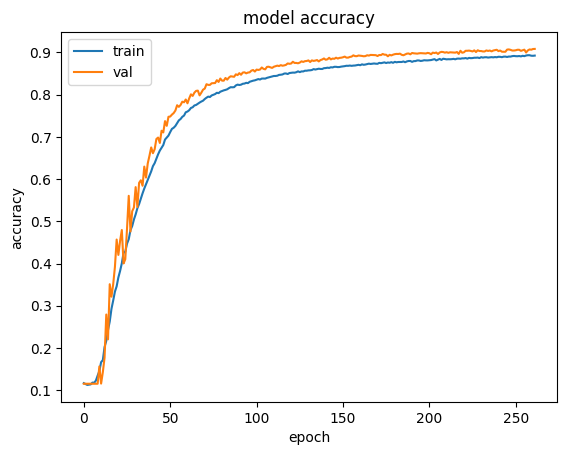

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

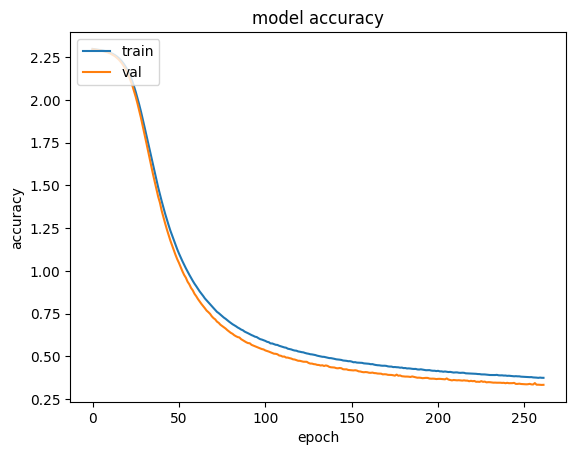

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

157/157 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

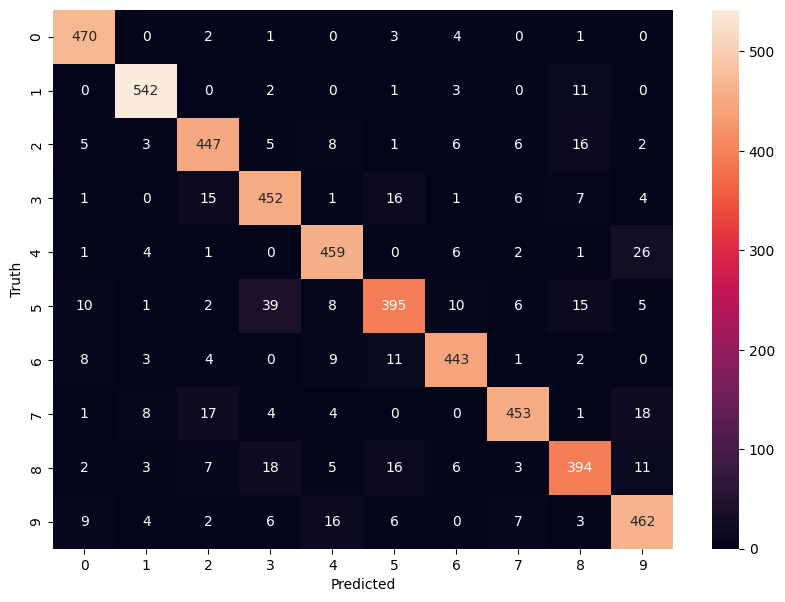

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Analyse du meillieur modèle avec dropout réduit + early stopping

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))
  model.add(Dropout(0.2))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.01))

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=128, epochs=500,
            verbose=2,
            callbacks=[callback],
            validation_data=(X_val, Y_val))

Epoch 1/500
469/469 - 3s - loss: 2.2993 - accuracy: 0.1261 - val_loss: 2.2971 - val_accuracy: 0.1152 - 3s/epoch - 6ms/step
Epoch 2/500
469/469 - 2s - loss: 2.2979 - accuracy: 0.1124 - val_loss: 2.2960 - val_accuracy: 0.1152 - 2s/epoch - 4ms/step
Epoch 3/500
469/469 - 1s - loss: 2.2968 - accuracy: 0.1124 - val_loss: 2.2947 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 4/500
469/469 - 1s - loss: 2.2954 - accuracy: 0.1124 - val_loss: 2.2933 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 5/500
469/469 - 1s - loss: 2.2938 - accuracy: 0.1125 - val_loss: 2.2912 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 6/500
469/469 - 1s - loss: 2.2919 - accuracy: 0.1126 - val_loss: 2.2893 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 7/500
469/469 - 1s - loss: 2.2897 - accuracy: 0.1154 - val_loss: 2.2865 - val_accuracy: 0.1628 - 1s/epoch - 3ms/step
Epoch 8/500
469/469 - 1s - loss: 2.2873 - accuracy: 0.1240 - val_loss: 2.2837 - val_accuracy: 0.1152 - 1s/epoch - 3ms/step
Epoch 9/500
469/

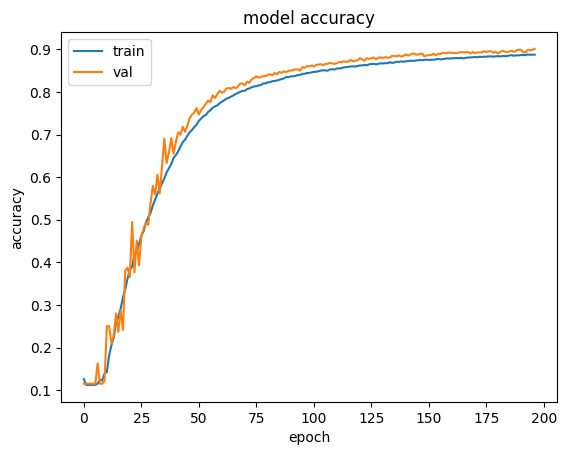

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

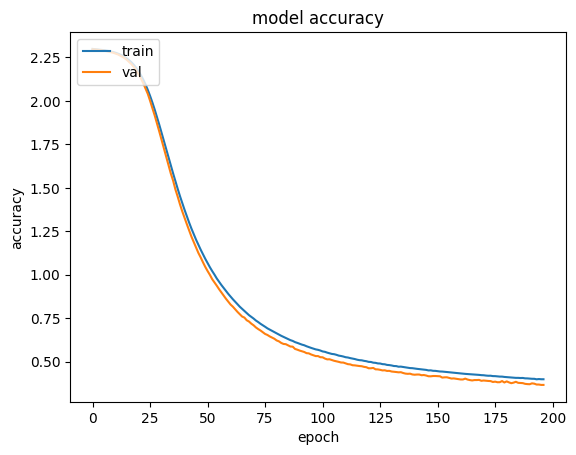

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

157/157 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

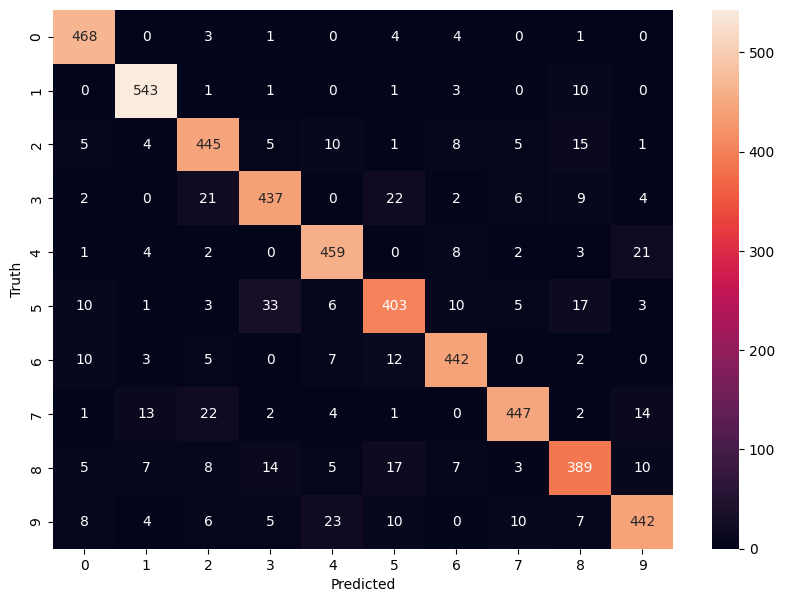

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Analyse du meillieurs modèle ayant overfit en ajoutant dropout + early stopping

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))
  model.add(Dropout(0.2))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.0001))

  checkpointer = ModelCheckpoint(filepath='my_model.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', periode=1)
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=64, epochs=500,
            verbose=2,
            callbacks=[callback],
            validation_data=(X_val, Y_val))

Epoch 1/500
938/938 - 6s - loss: 1.9030 - accuracy: 0.4201 - val_loss: 1.0803 - val_accuracy: 0.7494 - 6s/epoch - 7ms/step
Epoch 2/500
938/938 - 3s - loss: 0.7606 - accuracy: 0.8051 - val_loss: 0.5379 - val_accuracy: 0.8592 - 3s/epoch - 4ms/step
Epoch 3/500
938/938 - 5s - loss: 0.4984 - accuracy: 0.8636 - val_loss: 0.4132 - val_accuracy: 0.8914 - 5s/epoch - 5ms/step
Epoch 4/500
938/938 - 3s - loss: 0.4158 - accuracy: 0.8837 - val_loss: 0.3614 - val_accuracy: 0.9010 - 3s/epoch - 3ms/step
Epoch 5/500
938/938 - 4s - loss: 0.3774 - accuracy: 0.8921 - val_loss: 0.3362 - val_accuracy: 0.9062 - 4s/epoch - 4ms/step
Epoch 6/500
938/938 - 4s - loss: 0.3491 - accuracy: 0.9001 - val_loss: 0.3187 - val_accuracy: 0.9104 - 4s/epoch - 4ms/step
Epoch 7/500
938/938 - 3s - loss: 0.3299 - accuracy: 0.9047 - val_loss: 0.3022 - val_accuracy: 0.9132 - 3s/epoch - 3ms/step
Epoch 8/500
938/938 - 4s - loss: 0.3125 - accuracy: 0.9091 - val_loss: 0.2838 - val_accuracy: 0.9188 - 4s/epoch - 4ms/step
Epoch 9/500
938/

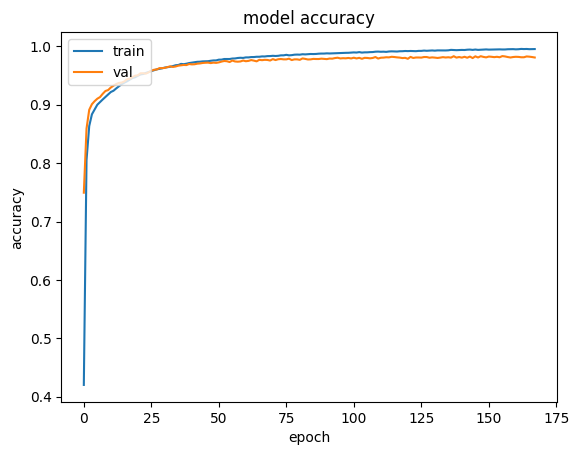

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

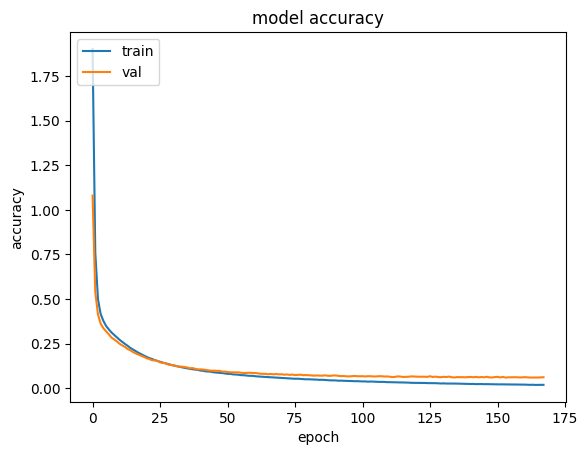

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

157/157 [==============================] - 0s 1ms/step


Text(95.72222222222221, 0.5, 'Truth')

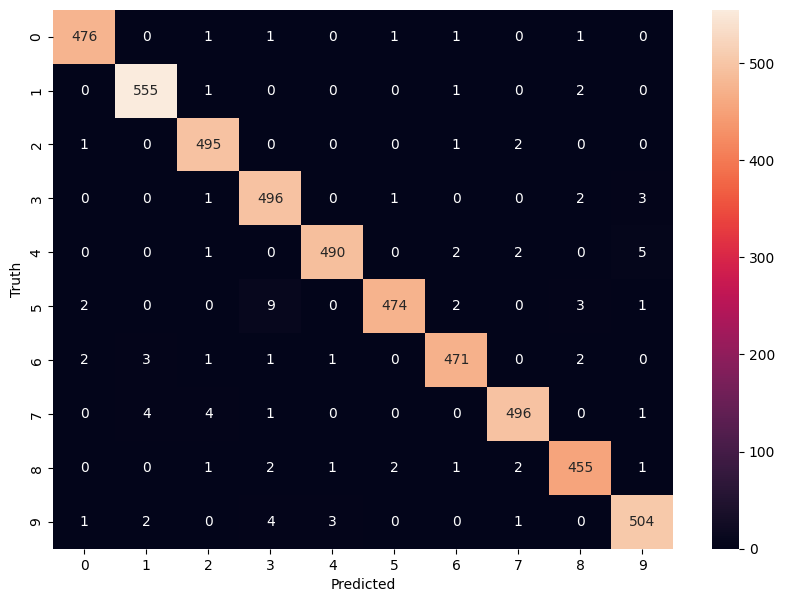

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Analyse de l'impacte des fonctions d'optimisations

In [ ]:
opt_functions = ["SGD", "Adam", "Adamax", "RMSprop", "Adagrad", "Nadam"]
results = []

In [ ]:
def get_opt_function(opt_f):

  if opt_f == "SGD":
    return SGD()
  elif opt_f == "Adam":
    return Adam()
  elif opt_f == "Adamax":
    return Adamax()
  elif opt_f == "RMSprop":
    return RMSprop()
  elif opt_f == "Adagrad":
    return Adagrad()
  elif opt_f == "Nadam":
    return Nadam()

In [ ]:
for optf in opt_functions:
  with tf.device(device_name):
    print(optf+" start")
    # On crée un modèle de classification simple
    model = Sequential()
    model.add(Dense(1024, input_shape=(784,)))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    # on compile notre modèle
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=get_opt_function(optf))

    checkpointer = ModelCheckpoint(filepath='my_model.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', periode=1)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    # Entrainement du modèle sur 500 epochs
    history = model.fit(X_train, Y_train,
              batch_size=64, epochs=500,
              verbose=0,
              callbacks=[callback],
              validation_data=(X_val, Y_val))

    results.append([optf, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'], model])
    print(optf+" done")

SGD start
SGD done
Adam start
Adam done
Adamax start
Adamax done
RMSprop start
RMSprop done
Adagrad start
Adagrad done
Nadam start
Nadam done


In [ ]:
gridsearch = []
titles = ["Fonction d'optimisation", "Accuracy", "Loss", "Val_accuracy", "Val_loss"]
for r in results:
  gridsearch.append([r[0], r[1][-1], r[2][-1], r[3][-1], r[4][-1]])
benchmark = pd.DataFrame(data=gridsearch, columns=titles)
benchmark

,Fonction d'optimisation,Accuracy,Loss,Val_accuracy,Val_loss
0,SGD,0.994783,0.023082,0.9814,0.057854
1,Adam,0.998200,0.006037,0.9810,0.102969
2,Adamax,1.000000,0.000256,0.9826,0.074738
3,RMSprop,0.999783,0.000608,0.9844,0.082853
4,Adagrad,0.970983,0.107793,0.9700,0.110180
5,Nadam,0.997283,0.008174,0.9832,0.096913


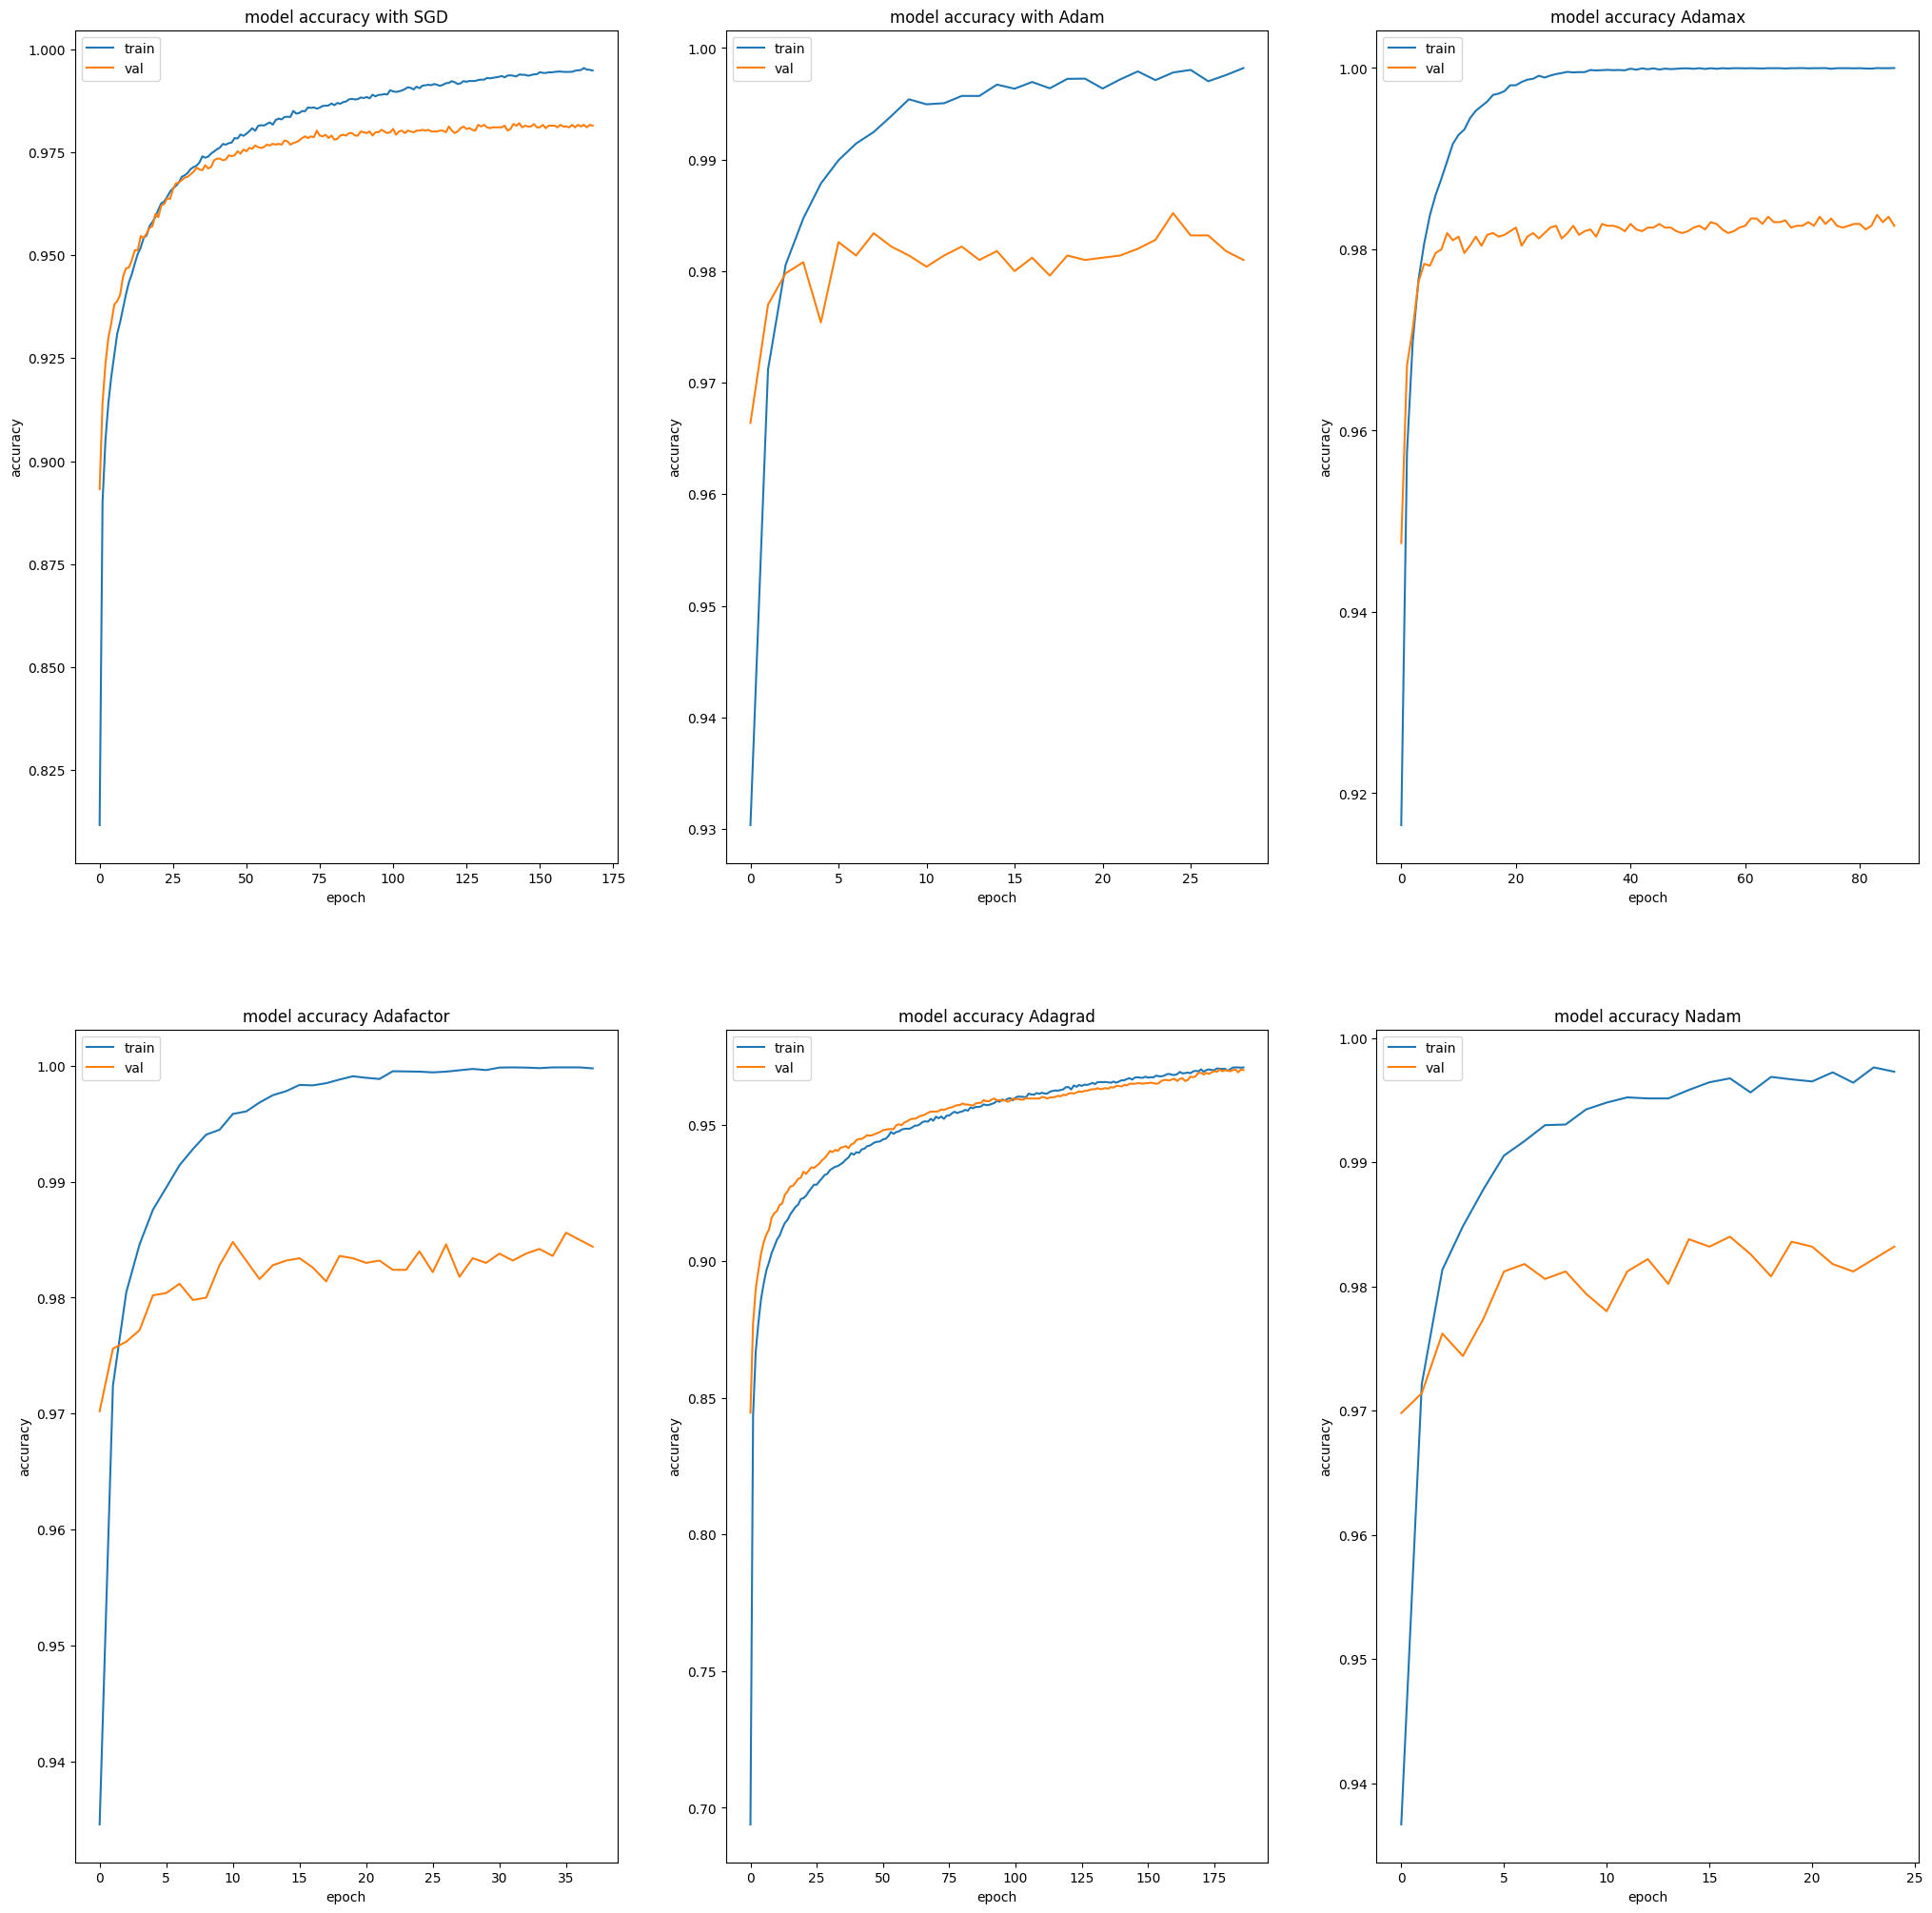

In [ ]:
fig, axes = plt.subplots(2, 3,figsize=(25, 25))

axes[0, 0].plot(results[0][1])
axes[0, 0].plot(results[0][3])
axes[0, 0].set_title('model accuracy with SGD')
axes[0, 0].set_ylabel('accuracy')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].legend(['train', 'val'], loc='upper left')

axes[0, 1].plot(results[1][1])
axes[0, 1].plot(results[1][3])
axes[0, 1].set_title('model accuracy with Adam')
axes[0, 1].set_ylabel('accuracy')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].legend(['train', 'val'], loc='upper left')

axes[0, 2].plot(results[2][1])
axes[0, 2].plot(results[2][3])
axes[0, 2].set_title('model accuracy Adamax')
axes[0, 2].set_ylabel('accuracy')
axes[0, 2].set_xlabel('epoch')
axes[0, 2].legend(['train', 'val'], loc='upper left')

axes[1, 0].plot(results[3][1])
axes[1, 0].plot(results[3][3])
axes[1, 0].set_title('model accuracy Adafactor')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].legend(['train', 'val'], loc='upper left')

axes[1, 1].plot(results[4][1])
axes[1, 1].plot(results[4][3])
axes[1, 1].set_title('model accuracy Adagrad')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].legend(['train', 'val'], loc='upper left')

axes[1, 2].plot(results[5][1])
axes[1, 2].plot(results[5][3])
axes[1, 2].set_title('model accuracy Nadam')
axes[1, 2].set_ylabel('accuracy')
axes[1, 2].set_xlabel('epoch')
axes[1, 2].legend(['train', 'val'], loc='upper left')

plt.show()

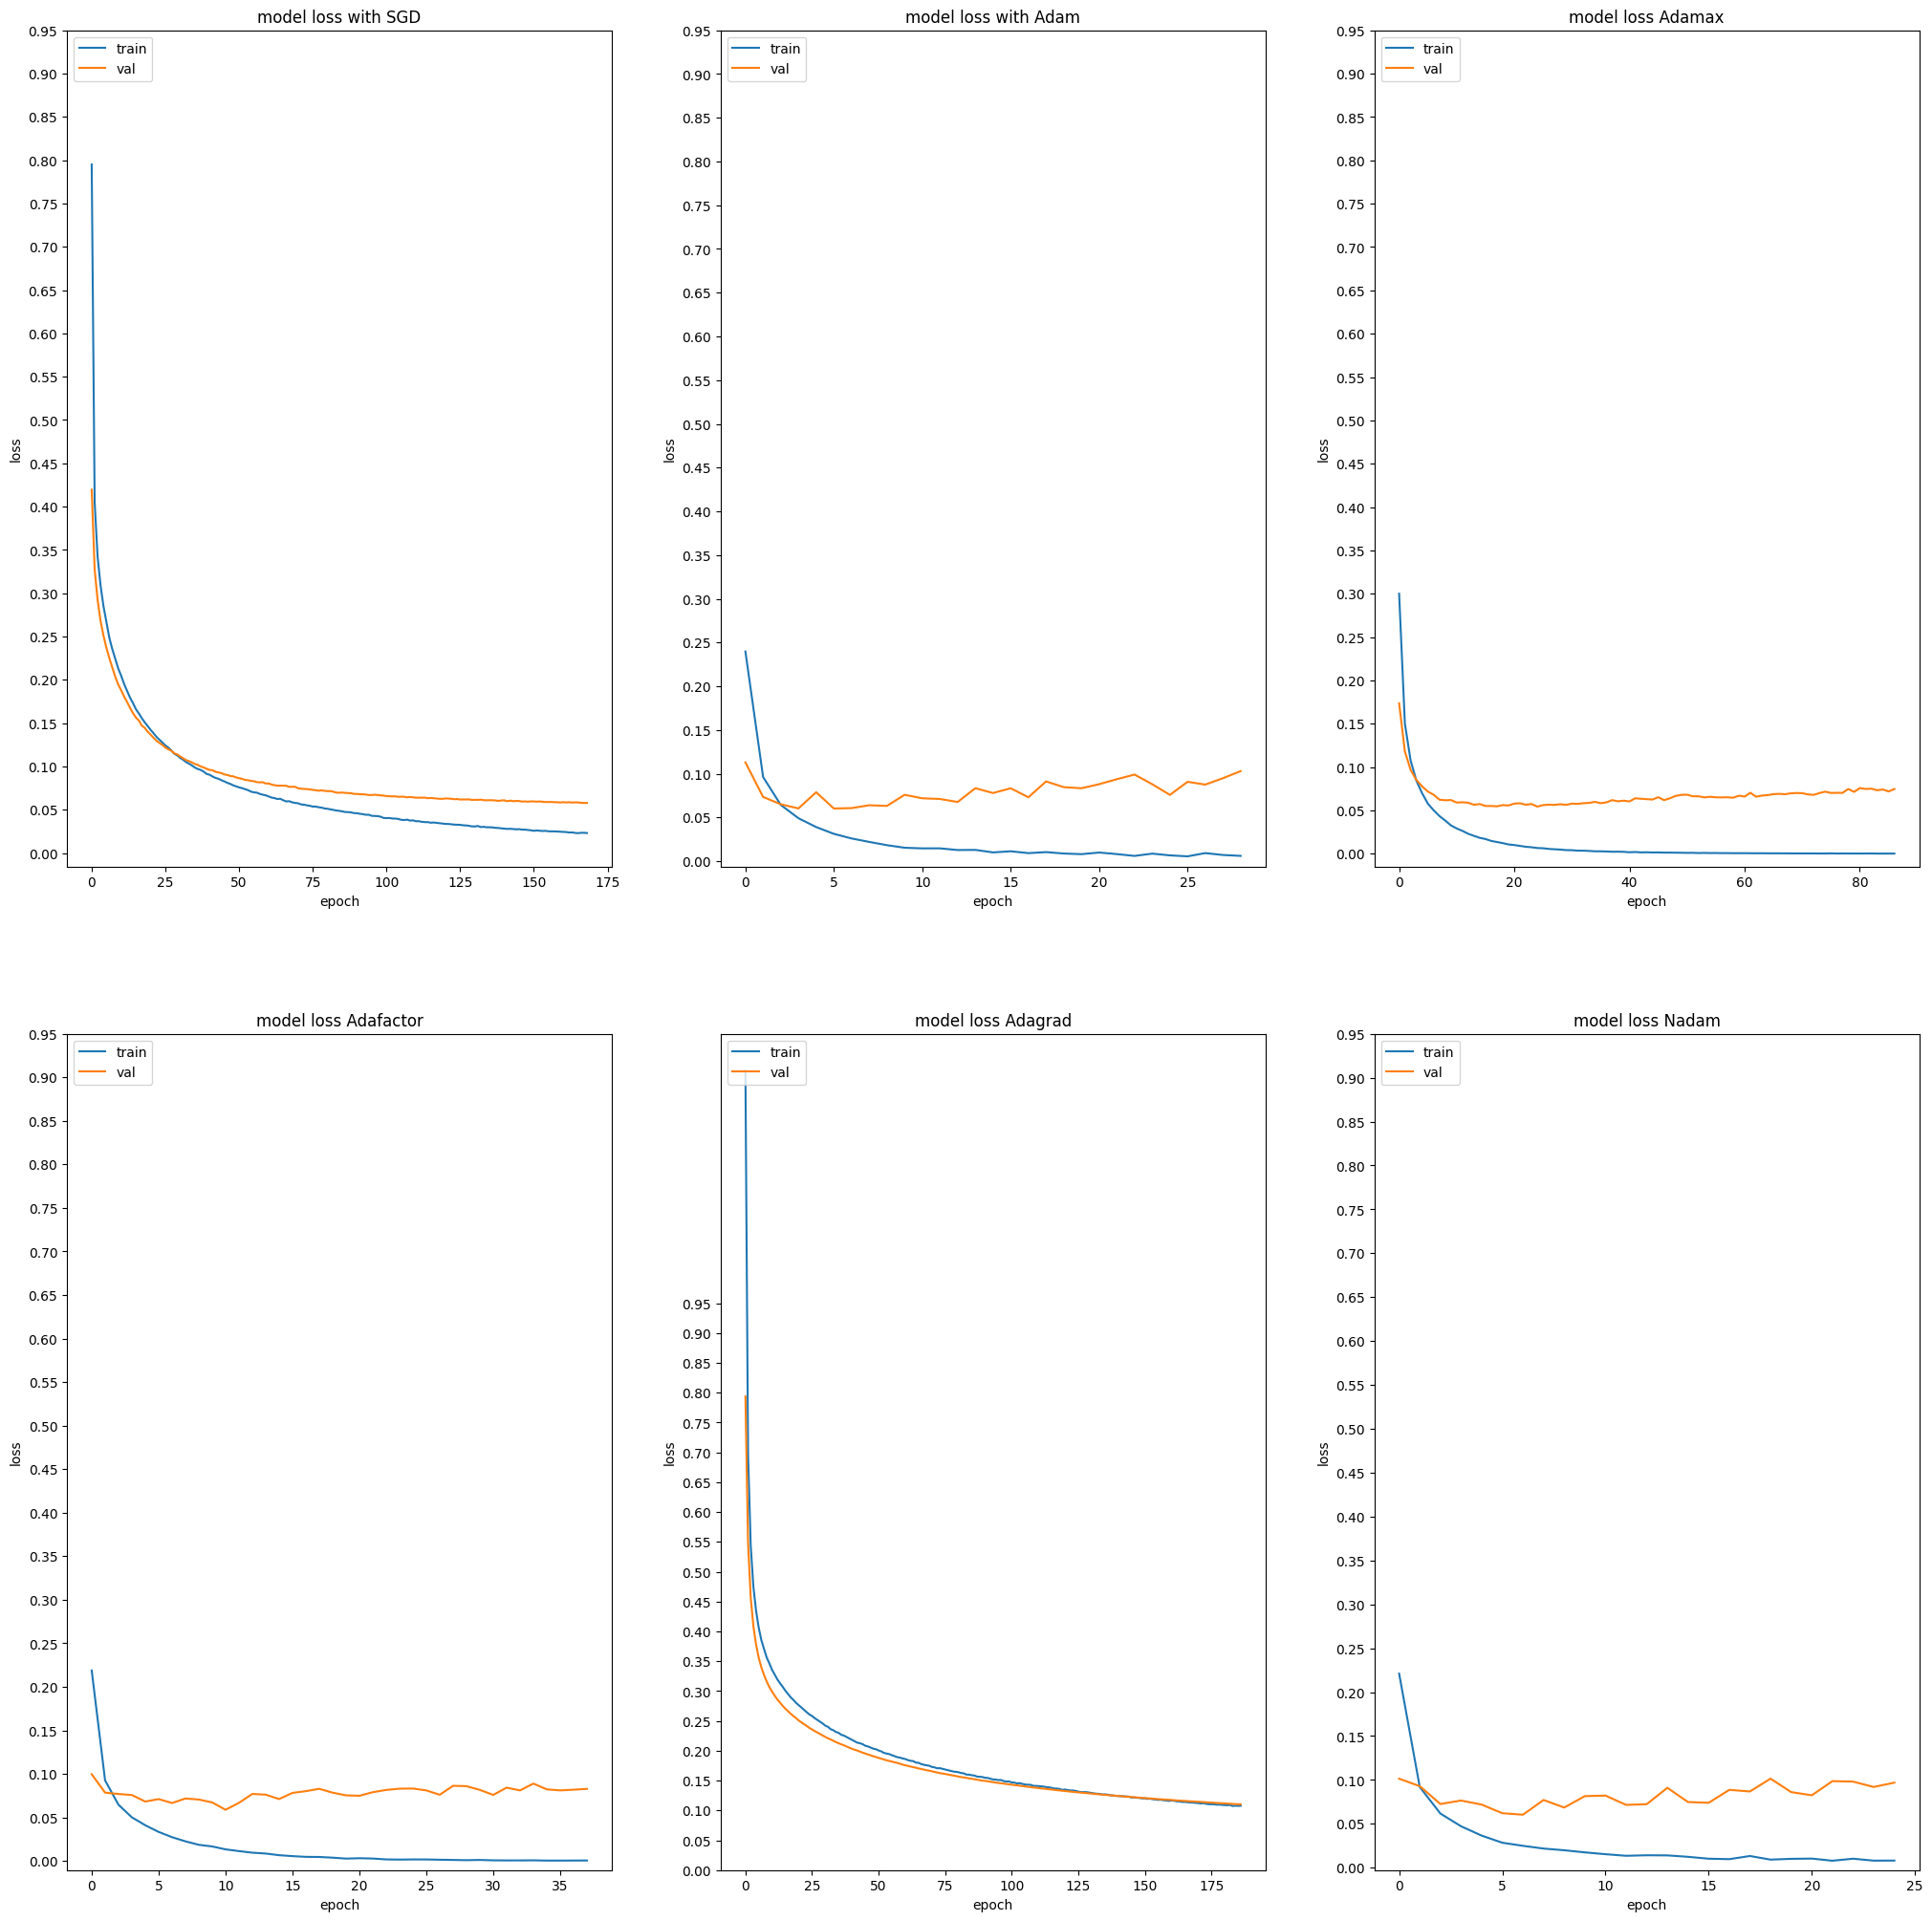

In [ ]:
fig, axes = plt.subplots(2, 3,figsize=(25, 25))

axes[0, 0].plot(results[0][2])
axes[0, 0].plot(results[0][4])
axes[0, 0].set_yticks(np.arange(0, 1, 0.05))
axes[0, 0].set_title('model loss with SGD')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].legend(['train', 'val'], loc='upper left')

axes[0, 1].plot(results[1][2])
axes[0, 1].plot(results[1][4])
axes[0, 1].set_yticks(np.arange(0, 1, 0.05))
axes[0, 1].set_title('model loss with Adam')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].legend(['train', 'val'], loc='upper left')

axes[0, 2].plot(results[2][2])
axes[0, 2].plot(results[2][4])
axes[0, 2].set_yticks(np.arange(0, 1, 0.05))
axes[0, 2].set_title('model loss Adamax')
axes[0, 2].set_ylabel('loss')
axes[0, 2].set_xlabel('epoch')
axes[0, 2].legend(['train', 'val'], loc='upper left')

axes[1, 0].plot(results[3][2])
axes[1, 0].plot(results[3][4])
axes[1, 0].set_yticks(np.arange(0, 1, 0.05))
axes[1, 0].set_title('model loss Adafactor')
axes[1, 0].set_ylabel('loss')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].legend(['train', 'val'], loc='upper left')

axes[1, 1].plot(results[4][2])
axes[1, 1].plot(results[4][4])
axes[1, 1].set_yticks(np.arange(0, 1, 0.05))
axes[1, 1].set_title('model loss Adagrad')
axes[1, 1].set_ylabel('loss')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].legend(['train', 'val'], loc='upper left')

axes[1, 2].plot(results[5][2])
axes[1, 2].plot(results[5][4])
axes[1, 2].set_yticks(np.arange(0, 1, 0.05))
axes[1, 2].set_title('model loss Nadam')
axes[1, 2].set_ylabel('loss')
axes[1, 2].set_xlabel('epoch')
axes[1, 2].legend(['train', 'val'], loc='upper left')

plt.show()

157/157 [==============================] - 0s 2ms/step


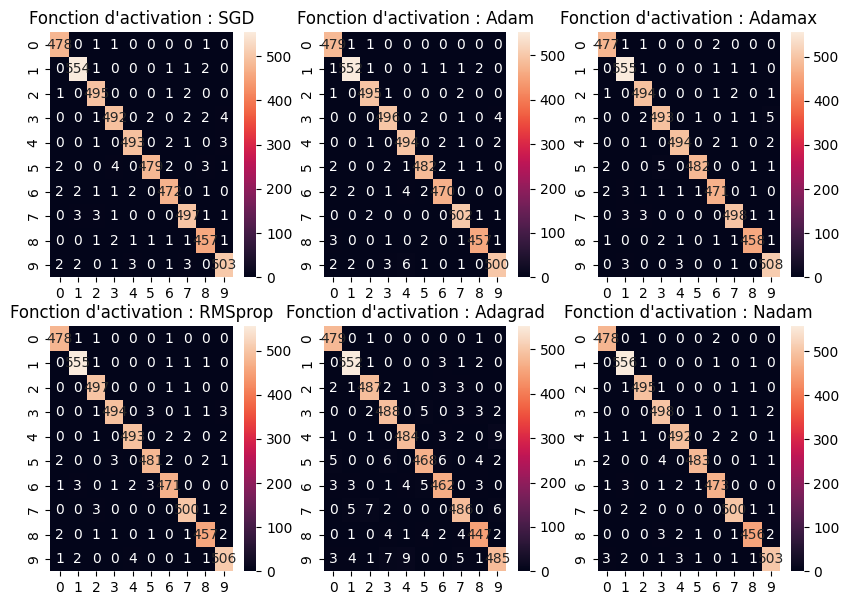

In [ ]:
fig, axes = plt.subplots(2, 3,figsize=(10, 7))
for model, ax in zip(results, axes.ravel()):
  y_predicted = model[-1].predict(X_test)
  y_predicted_labels = [np.argmax(i) for i in y_predicted]
  cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

  sn.heatmap(cm, annot=True, fmt='d', ax=ax).set(title="Fonction d'activation : "+model[0])

plt.show()

# Utilisation de plusieurs couches cachée et de batch normalization

In [ ]:
with tf.device(device_name):
  # On crée un modèle de classification simple
  model = Sequential()
  model.add(Dense(1024, input_shape=(784,)))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  # on compile notre modèle
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(epsilon=0.0001))

  checkpointer = ModelCheckpoint(filepath='my_model.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', periode=1)
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  # Entrainement du modèle sur "nbe" epochs
  history = model.fit(X_train, Y_train,
            batch_size=64, epochs=500,
            verbose=2,
            callbacks=[callback],
            validation_data=(X_val, Y_val))

Epoch 1/500
938/938 - 8s - loss: 0.2339 - accuracy: 0.9282 - val_loss: 0.1042 - val_accuracy: 0.9676 - 8s/epoch - 9ms/step
Epoch 2/500
938/938 - 6s - loss: 0.1207 - accuracy: 0.9612 - val_loss: 0.0941 - val_accuracy: 0.9720 - 6s/epoch - 6ms/step
Epoch 3/500
938/938 - 5s - loss: 0.0980 - accuracy: 0.9686 - val_loss: 0.0789 - val_accuracy: 0.9738 - 5s/epoch - 5ms/step
Epoch 4/500
938/938 - 6s - loss: 0.0843 - accuracy: 0.9730 - val_loss: 0.0702 - val_accuracy: 0.9782 - 6s/epoch - 6ms/step
Epoch 5/500
938/938 - 5s - loss: 0.0772 - accuracy: 0.9761 - val_loss: 0.0626 - val_accuracy: 0.9796 - 5s/epoch - 5ms/step
Epoch 6/500
938/938 - 6s - loss: 0.0655 - accuracy: 0.9785 - val_loss: 0.0615 - val_accuracy: 0.9812 - 6s/epoch - 6ms/step
Epoch 7/500
938/938 - 5s - loss: 0.0603 - accuracy: 0.9801 - val_loss: 0.0647 - val_accuracy: 0.9786 - 5s/epoch - 5ms/step
Epoch 8/500
938/938 - 5s - loss: 0.0557 - accuracy: 0.9821 - val_loss: 0.0605 - val_accuracy: 0.9824 - 5s/epoch - 5ms/step
Epoch 9/500
938/

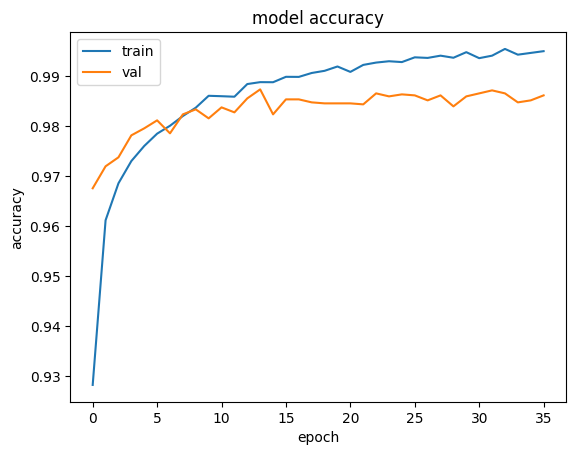

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

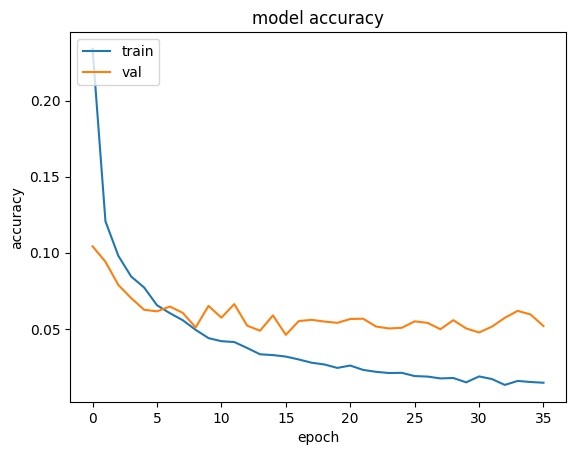

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict(X_test)

157/157 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

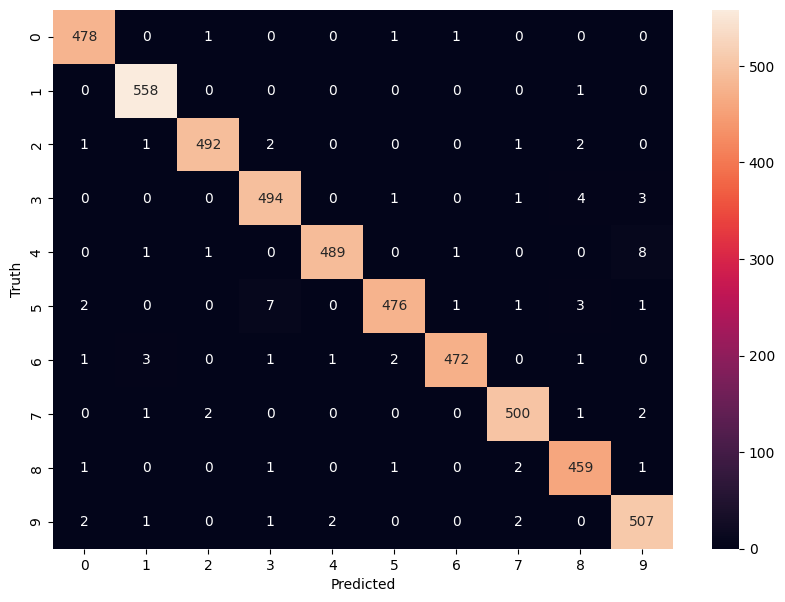

In [ ]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Conclusion

On ne peut pas trouver de manière général un ensemble d'hyper paramètre qui peuvent etre utilisé par tout les modèles cela dépend de plusieurs choses tel que le nombre de données, la complexité du modèles, ainsi que la tache devant etre effectué. A noter aussi que bcp de variations de combinaisons ne change pas grand choses aux performances des modèles. Pour finir il faut aussi faire attention à ne pas tomber dans le surapprentissage mais cela peut etre éviter en utilisant des méthodes tel que le dropout et la regularisation et cela indépendament des hyper paramètres.